In [1]:
import tensorflow as tf
import time

gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=1)

In [96]:
import tarfile
import re
import urllib.request
import os
import random

class ImdbMovieReviews:
    DEFAULT_URL = \
        'http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'
    TOKEN_REGEX = re.compile(r'[A-Za-z]+|[!?.:,()]')
    
    def __init__(self):
        self._cache_dir = './imdb'
        self._url = 'http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'
        
        if not os.path.isfile(self._cache_dir):
            urllib.request.urlretrieve(self._url, self._cache_dir)
        self.filepath = self._cache_dir

    def __iter__(self):
        with tarfile.open(self.filepath) as archive:
            items = archive.getnames()
            for filename in archive.getnames():
                if filename.startswith('aclImdb/test/pos/'):
                    yield self._read(archive, filename), True
                elif filename.startswith('aclImdb/test/neg/'):
                    yield self._read(archive, filename), False
                    
    def _read(self, archive, filename):
        with archive.extractfile(filename) as file_:
            data = file_.read().decode('utf-8')
            data = type(self).TOKEN_REGEX.findall(data)
            data = [x.lower() for x in data]
            return data

In [3]:
import numpy as np
import spacy

# Spacy is my favourite nlp framework, which havu builtin word embeddings trains on wikipesia
from spacy.lang.en import English

class Embedding:
    
    def __init__(self):
#          spaCy makes using word vectors very easy. 
#             The Lexeme , Token , Span  and Doc  classes all have a .vector property,
#             which is a 1-dimensional numpy array of 32-bit floats:
        self.parser = spacy.load('en_vectors_web_lg')
#         self._length = length
        self.dimensions = 300
        
    def __call__(self, sequence, length):
        # DO I really need them to be equal length?
        # Let's assume I'm not
        data = np.zeros((length, self.dimensions))
        # you can access known words from the parser's vocabulary
        embedded = [self.parser.vocab[w].vector for w in sequence]
        data[:len(sequence)] = embedded
        return data

In [4]:
import itertools

def preprocess_batched_split(iterator, embedding, batch_size):
    iterator = iter(iterator)
    while True:
        batch = []
        labelss = []
        sentence_sizes_batch = []
        for index in range(batch_size):
            text, label = next(iterator)
            sents = [list(y) for x, y in itertools.groupby(text, lambda z: z == '.') if not x]
            sentence_sizes = [len(s) for s in sents]
            text_embed = [embedding(sent) for sent in sents]
            
            batch.append(text_embed)
            labelss.append(label)
            sentence_sizes_batch.append(sentence_sizes)
            
        labels_batch = np.array(labelss, dtype=np.int32)
        sent_per_doc = np.array([len(x) for x in sentence_sizes_batch])
        words_per_sent_per_doc = np.array(sentence_sizes_batch)
        yield np.array(batch), labels_batch, words_per_sent_per_doc, sent_per_doc

In [5]:
import itertools

def preprocess_batched_split2(iterator, embedding, batch_size):
    iterator = iter(iterator)
    while True:
        batch, labels_b = zip(*itertools.islice(iterator, batch_size))
        
        sents_b = [[list(y) for x, y in itertools.groupby(doc, lambda z: z == '.') if not x] for doc in batch]

        sentence_sizes_b = [[len(sent) for sent in doc] for doc in sents_b]
        sentence_size = max(map(max, sentence_sizes_b))
        
        document_sizes = np.array([len(doc) for doc in sentence_sizes_b], dtype=np.int32)
        document_size = document_sizes.max()

        sentence_sizes_np = np.zeros(shape=[batch_size, document_size], dtype=np.int32)
        for bi, ds, ss in zip(range(sentence_sizes_np.shape[0]), document_sizes, sentence_sizes_b):
            sentence_sizes_np[bi][:ds] = ss
        
        text_embed_b = np.zeros((batch_size, document_size, sentence_size, 300))

        for i, ds, doc_sents in zip(range(text_embed_b.shape[0]), document_sizes, sents_b):
            doc_sents_embed = np.array([embedding(sent, sentence_size) for sent in doc_sents])
            text_embed_b[i][:ds] = doc_sents_embed
        
        yield text_embed_b, np.array(labels_b, dtype=np.int32), np.array(document_sizes), sentence_sizes_np, sents_b

In [6]:
reviews = list(ImdbMovieReviews())

In [7]:
random.shuffle(reviews)

In [8]:
#################################################

In [9]:
%load_ext autoreload
%autoreload 1
%aimport HanSequenceLabellingModel
%aimport model_components
%aimport

Modules to reload:
HanSequenceLabellingModel model_components

Modules to skip:



In [77]:
batches_split = preprocess_batched_split2(reviews, Embedding(), batch_size=10)

In [11]:
from HanSequenceLabellingModel import HanSequenceLabellingModel

In [12]:
def HAN_model_1(session, restore_only=False):
    """Hierarhical Attention Network"""
    import tensorflow as tf
    try:
        from tensorflow.contrib.rnn import GRUCell, MultiRNNCell, DropoutWrapper
    except ImportError:
        MultiRNNCell = tf.nn.rnn_cell.MultiRNNCell
        GRUCell = tf.nn.rnn_cell.GRUCell
    from bn_lstm import BNLSTMCell
    #from HAN_model import HANClassifierModel

    is_training = tf.placeholder(dtype=tf.bool, name='is_training')

    cell = BNLSTMCell(80, is_training) # h-h batchnorm LSTMCell
    cell = MultiRNNCell([cell]*5)

    model = HanSequenceLabellingModel(
            embedding_size=300,
            classes=2,
            word_cell=cell,
            sentence_cell=cell,
            word_output_size=300,
            sentence_output_size=300,
            learning_rate=0.001,
            max_grad_norm=5.0,
            dropout_keep_proba=0.5,
            is_training=is_training,
    )

    saver = tf.train.Saver(tf.global_variables())
    checkpoint_dir = 'checkpoints'
    checkpoint = tf.train.get_checkpoint_state(checkpoint_dir)
    if checkpoint:
        print("Reading model parameters from %s" % checkpoint.model_checkpoint_path)
        saver.restore(session, checkpoint.model_checkpoint_path)
    elif restore_only:
        raise FileNotFoundError("Cannot restore model")
    else:
        print("Created model with fresh parameters")
        session.run(tf.global_variables_initializer())
        
    return model, saver

In [13]:
tf.reset_default_graph()

config = tf.ConfigProto(allow_soft_placement=True)

with tf.Session(config=config) as s:
    model, saver = HAN_model_1(s)
    tflog_dir = 'tf_logs'
    summary_writer = tf.summary.FileWriter(tflog_dir, graph=tf.get_default_graph())

    for i, (data, labels_batch, sent_per_doc, words_per_sent_per_doc) in enumerate(batches_split):

        fd = {
            model.is_training: True,
            model.inputs_embedded: data,
            model.word_lengths: words_per_sent_per_doc,
            model.sentence_lengths: sent_per_doc,
            model.labels: labels_batch,
            model.sample_weights: np.ones(shape=(10))
        }

        t0 = time.clock()
        step, summaries, loss, accuracy, _ = s.run([
                model.global_step,
                model.summary_op,
                model.loss,
                model.accuracy,
                model.train_op,
        ], feed_dict=fd)
        td = time.clock() - t0

        summary_writer.add_summary(summaries, global_step=step)

        checkpoint_frequency = 100
        eval_frequency = 1
        
        if step % 1 == 0:
            print('step %s, loss=%s, accuracy=%s, t=%s, inputs=%s' % (step, loss, accuracy, round(td, 2), fd[model.inputs_embedded].shape))
        if step != 0 and step % checkpoint_frequency == 0:
            print('checkpoint & graph meta')
            checkpoint_path = 'checkpoints/checkpoint'
            saver.save(s, checkpoint_path, global_step=step)
            print('checkpoint done')

Reading model parameters from checkpoints/checkpoint-200
INFO:tensorflow:Restoring parameters from checkpoints/checkpoint-200


ValueError: too many values to unpack (expected 4)

# Attention visualization

Для расскаски текста используется библиотека ansicolors-1.1.8. 

attention взят уже после softmax и в конце отнормирован по данному куску текста.

In [104]:
from __future__ import print_function
from colors import color

tf.reset_default_graph()

config = tf.ConfigProto(allow_soft_placement=True)

with tf.Session(config=config) as s:
    model, saver = HAN_model_1(s, True)

    for i, (data, labels_batch, sent_per_doc, words_per_sent_per_doc, sents_b) in enumerate(batches_split):
        fd = {
            model.is_training: True,
            model.inputs_embedded: data,
            model.word_lengths: words_per_sent_per_doc,
            model.sentence_lengths: sent_per_doc,
            model.labels: labels_batch,
            model.sample_weights: np.ones(shape=(10))
        }

        t0 = time.clock()
        attention_weights_word = s.run(
            model.attention_weights_word
        , feed_dict=fd)
        
        attention_weights_sent = s.run(model.attention_weights_sent, feed_dict=fd)
        td = time.clock() - t0
            
        mxsent = 0
        mxval = 0
        
        for g in range(len(sents_b[0])):
            mxsent = max(mxsent, attention_weights_sent[0][g])
            for h in range(len(attention_weights_word[g])):
                mxval = max(mxval, attention_weights_word[g][h])
        
        
        for sent_num in range(len(sents_b[0])):        
            val = 255 - int(255 *  attention_weights_sent[0][sent_num]/mxsent)
            
            print(color('   ', 'black', '#' + '%02x'%val + '%02x'%val + 'ff'), end='')
            
            for g in range(len(sents_b[0][sent_num])):
                val1 = 255 - int(255 * attention_weights_word[sent_num][g]/mxval)
                print(color(sents_b[0][sent_num][g], 'black', '#' + '%02x'%val1 + 'ff' + '%02x'%val1), end=' ')
            print()
        break

Reading model parameters from checkpoints/checkpoint-2400
INFO:tensorflow:Restoring parameters from checkpoints/checkpoint-2400
   i didn t think it was possible for a horror comedy film to fail so abysmally on both fronts 
   really awful 
   the fact that it doesn t take itself seriously ( usually a good thing ) works against it , primarily because the actors are so wooden you really would swear they are reading cue cards 
   on the upshot though 
   the mst k version , as always , has a few laughs 


# Distribution of "good" and "bad"

In [93]:
tf.reset_default_graph()

config = tf.ConfigProto(allow_soft_placement=True)

goodAtPos = []
goodAtNeg = []
badAtPos = []
badAtNeg = []

with tf.Session(config=config) as s:
    model, saver = HAN_model_1(s, True)

    for i, (data, labels_batch, sent_per_doc, words_per_sent_per_doc, sents_b) in enumerate(batches_split):
        fd = {
            model.is_training: True,
            model.inputs_embedded: data,
            model.word_lengths: words_per_sent_per_doc,
            model.sentence_lengths: sent_per_doc,
            model.labels: labels_batch,
            model.sample_weights: np.ones(shape=(10))
        }

        t0 = time.clock()
        attention_weights_word = s.run(
            model.attention_weights_word
        , feed_dict=fd)
        
        attention_weights_sent = s.run(model.attention_weights_sent, feed_dict=fd)
        td = time.clock() - t0
           
        for bt in range(len(sents_b)):
            for sent_num in range(len(sents_b[bt])):
                for g in range(len(sents_b[bt][sent_num])):
                    val = attention_weights_word[bt * len(attention_weights_sent[0]) + sent_num][g]
                    if (sents_b[bt][sent_num][g] == 'good'):
                        if labels_batch[bt] == True:
                            goodAtPos.append(val)
                        else:
                            goodAtNeg.append(val)
                        
                    if (sents_b[bt][sent_num][g] == 'bad'):
                        if labels_batch[bt] == True:
                            badAtPos.append(val)
                        else:
                            badAtNeg.append(val)
                        
        
        print(i)
        if (i >= 1000):

            break

Reading model parameters from checkpoints/checkpoint-2400
INFO:tensorflow:Restoring parameters from checkpoints/checkpoint-2400
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
24

In [ ]:
На первом графике показано распределение слова good. Синий - в негативных отзывах, зеленый - положительных. 
Можно видеть, что в слувчае позитивного отзыва attention обычно бывает больше, чем в негативных отзывах.  

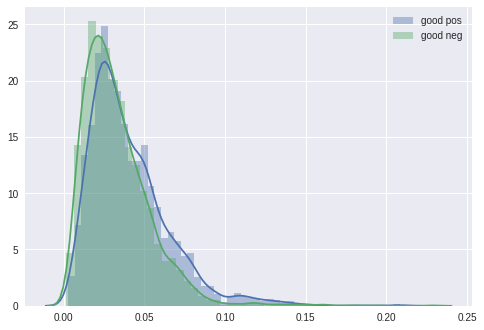

In [94]:
%matplotlib inline

from scipy import stats, integrate
import matplotlib.pyplot as plt

import seaborn as sns
sns.set(color_codes=True)
sns.distplot(goodAtPos, label="good pos")
sns.distplot(goodAtNeg, label="good neg")
plt.legend();

In [ ]:
На втором графике все тоже самое, но для слова bad. 
Здесь attention получается достаточно похожим, но в негативных случаях он все-таки немного больше 

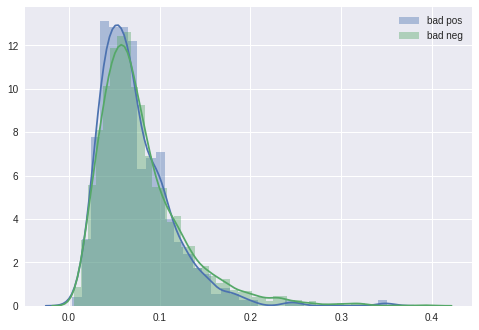

In [95]:
sns.set(color_codes=True)
sns.distplot(badAtPos, label="bad pos")
sns.distplot(badAtNeg, label="bad neg")
plt.legend();

In [101]:
tf.reset_default_graph()

config = tf.ConfigProto(allow_soft_placement=True)

cnt_rght = 0
cnt_wrng = 0

with tf.Session(config=config) as s:
    model, saver = HAN_model_1(s, True)

    for i, (data, labels_batch, sent_per_doc, words_per_sent_per_doc, sents_b) in enumerate(batches_split):
        fd = {
            model.is_training: True,
            model.inputs_embedded: data,
            model.word_lengths: words_per_sent_per_doc,
            model.sentence_lengths: sent_per_doc,
            model.sample_weights: np.ones(shape=(10))
        }

        t0 = time.clock()
        prediction = s.run(
            model.prediction
        , feed_dict=fd)
        
        td = time.clock() - t0
           
        for j in range(len(prediction)):
            if prediction[j] == labels_batch[j]:
                cnt_rght += 1
            else:
                cnt_wrng += 1
        
        print(i, "accuracy=", cnt_rght/(cnt_rght + cnt_wrng))

Reading model parameters from checkpoints/checkpoint-2400
INFO:tensorflow:Restoring parameters from checkpoints/checkpoint-2400
0 accuracy= 0.7
1 accuracy= 0.55
2 accuracy= 0.6333333333333333
3 accuracy= 0.7
4 accuracy= 0.74
5 accuracy= 0.7666666666666667
6 accuracy= 0.7857142857142857
7 accuracy= 0.7875
8 accuracy= 0.8
9 accuracy= 0.82
10 accuracy= 0.8090909090909091
11 accuracy= 0.8166666666666667
12 accuracy= 0.8307692307692308
13 accuracy= 0.8285714285714286
14 accuracy= 0.8333333333333334
15 accuracy= 0.8375
16 accuracy= 0.8235294117647058
17 accuracy= 0.8277777777777777
18 accuracy= 0.8368421052631579
19 accuracy= 0.83
20 accuracy= 0.8333333333333334
21 accuracy= 0.8363636363636363
22 accuracy= 0.8434782608695652
23 accuracy= 0.8375
24 accuracy= 0.836
25 accuracy= 0.8384615384615385
26 accuracy= 0.8444444444444444
27 accuracy= 0.8464285714285714
28 accuracy= 0.8482758620689655
29 accuracy= 0.8466666666666667
30 accuracy= 0.8516129032258064
31 accuracy= 0.846875
32 accuracy= 0.842

261 accuracy= 0.8610687022900764
262 accuracy= 0.8608365019011407
263 accuracy= 0.8606060606060606
264 accuracy= 0.8603773584905661
265 accuracy= 0.8609022556390977
266 accuracy= 0.8610486891385768
267 accuracy= 0.8611940298507462
268 accuracy= 0.8605947955390335
269 accuracy= 0.8607407407407407
270 accuracy= 0.8605166051660517
271 accuracy= 0.8606617647058824
272 accuracy= 0.8611721611721612
273 accuracy= 0.8613138686131386
274 accuracy= 0.8614545454545455
275 accuracy= 0.8608695652173913
276 accuracy= 0.8610108303249098
277 accuracy= 0.8607913669064748
278 accuracy= 0.860931899641577
279 accuracy= 0.8614285714285714
280 accuracy= 0.8619217081850534
281 accuracy= 0.8620567375886525
282 accuracy= 0.8625441696113074
283 accuracy= 0.8623239436619718
284 accuracy= 0.8610526315789474
285 accuracy= 0.8608391608391608
286 accuracy= 0.8602787456445993
287 accuracy= 0.8607638888888889
288 accuracy= 0.860553633217993
289 accuracy= 0.8610344827586207
290 accuracy= 0.8611683848797251
291 accuracy

KeyboardInterrupt: 

In [ ]:
С attention accuracy = 0.86, а без = 0.89 :( 